# 7. DQN 

## 7.1. Intro

## 7.2. CartPole Env

## 7.3. DQN
**function approximation** 

Q-learning:
$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha[R_t + \gamma \max_a Q(s_{t + 1}, a) - Q(s_t, a_t)]
$$

Approx:
$$
\omega^* = \argmin_\omega \frac1{2N} \sum_{i=1}^N\left[Q_\omega(s_i, a_i) - \left(r_i + \gamma \max_{a'} Q_\omega(s_i', a')\right)\right]^2
$$

### 7.3.1. Experience Replay

### 7.3.2. Target Network

伪代码 DQN：
1. 随机初始化$\omega, Q_\omega(s, a)$
2. 复制相同参数$\omega^- \leftarrow \omega$, 初始化目标网络$Q_{\omega'}$
3. 初始化经验回放池$R$ 
4. **for**  $e = 1 \rightarrow E$ **do**:
   1. 得到初始状态$s$
   2. **for** $t = 1 \rightarrow T$ **do**
      1. $\epsilon$-greedy根据$Q_\omega(s, a)$选择当前$s$的$a_t$
      2. 执行动作$a_t$, 得到环境反馈$r_t, s_{t+1}$
      3. 将$(s_t, a_t, r_t, s_{t+1})$ 放到回放池$R$中
      4. 如若$R$数据充足，从中采样$N$个$\left\{(s_i, a_i, r_i, s_{i+1})\right\}_{i=1:N}$
      5. 对每个数据，用目标网络计算$y_i = r_i + \gamma \max_aQ_{\omega^-}(s_{i + 1}, a)$
      6.  最小化损失函数$L = \frac1N\sum_{i}(y_i - Q_\omega(s_i, a_i))^2$ 以此更新当前网络$Q_\omega$
      7.  更新目标网络
    3. **end for**
5. **end for**

## 7.4. DQN 实现

In [1]:
import random
import gym
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
class ReplayBuffer:
  """经验回放"""
  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity) # 队列,先进先出
  
  def add(self, state, action, reward, next_state, done): # 将数据加入buffer
    self.buffer.append((state, action, reward, next_state, done))
    
  def sample(self, batch_size):   # 从buffer中采样数据,数量为batch_size
    transitions = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = zip(*transitions)
    return np.array(state), action, reward, np.array(next_state), done
  
  def size(self): # 目前buffer中数据的数量
    return len(self.buffer)
    

In [3]:
class Qnet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(Qnet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    return self.fc2(x)

In [4]:
class DQN:
  '''DQN '''
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                epsilon, target_update, device):
    self.action_dim = action_dim
    self.q_net = Qnet(state_dim, hidden_dim,
                      self.action_dim).to(device)
    # 目标网络
    self.target_q_net = Qnet(state_dim, hidden_dim, 
                              self.action_dim).to(device)
    # Adam 优化器
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
    self.gamma = gamma
    self.epsilon = epsilon
    self.target_update = target_update #  目标网络更新频率
    self.count = 0 # 计数器,记录更新次数
    self.device = device
    
  def take_action(self, state): # epsilon-贪婪策略采取动作
    if np.random.random() < self.epsilon:
      action = np.random.randint(self.action_dim)
    else:
      state = torch.tensor([state], dtype=torch.float).to(self.device)
      action = self.q_net(state).argmax().item()
    return action
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], 
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype = torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)
    q_values = self.q_net(states).gather(1, actions) # Q值
    # 下个状态的最大Q值
    max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
    q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) # TD
    dqn_loss = torch.mean(F.mse_loss(q_values, q_targets)) # 均方误差损失
    self.optimizer.zero_grad() 
    dqn_loss.backward()
    self.optimizer.step()
    
    if self.count % self.target_update == 0:
      self.target_q_net.load_state_dict(
        self.q_net.state_dict()
      ) # 更新目标网络
    self.count += 1

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name ='CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, 
            target_update, device)

return_list = []
for i in range(10):
  with tqdm(total=int(num_episodes / 10),desc='Iteration %d' % i) as pbar:
    for i_episode in range(int(num_episodes / 10)):
      episode_return = 0
      state, _ = env.reset(seed=0)
      done = False
      while not done:
        action = agent.take_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        episode_return += reward
        
        # 当buffer数据的数量超过一定值后,才进行Q网络训练
        if replay_buffer.size() > minimal_size:
          b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
          transition_dict = {
            'states': b_s,
            'actions': b_a,
            'next_states': b_ns,
            'rewards': b_r,
            'dones': b_d
          }
          agent.update(transition_dict)
      return_list.append(episode_return)
      if (i_episode + 1) % 10 == 0:
        pbar.set_postfix({
          'episode':
          '%d' % (num_episodes / 10 * i + i_episode + 1),
          'return':
          '%.3f' %np.mean(return_list[-10:])
        })
      pbar.update(1)



Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\dell\AppData\Local\Temp\ipykernel_43348\1326105600.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:50<00:00,  1.01s/it, episode=500, return=466.000]


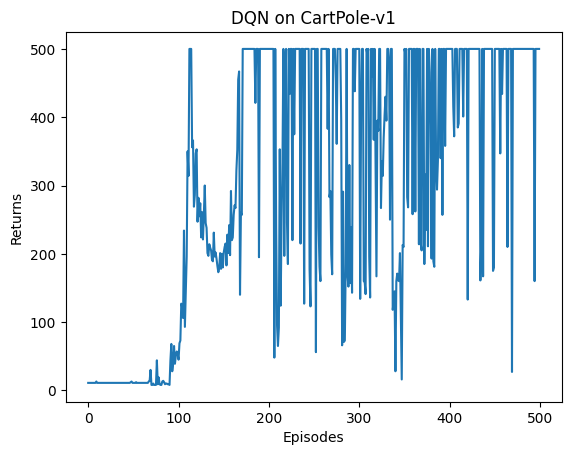

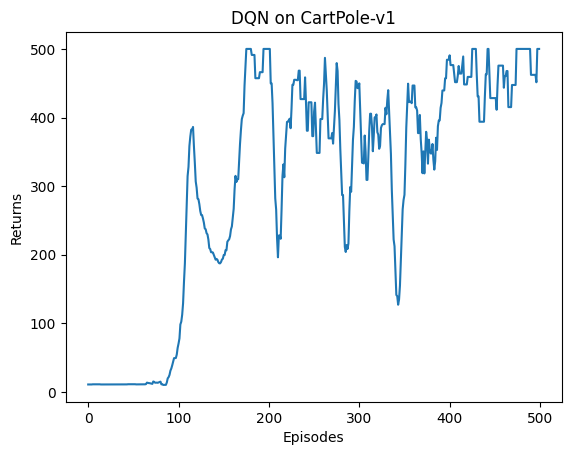

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

## 7.5. DQN with CNN

In [7]:
class ConvolutionalQnet(torch.nn.Module):
  def __init__(self, action_dim, in_channels=4):
    super(ConvolutionalQnet, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
    self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
    self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
    self.head = torch.nn.Linear(512, action_dim)
    
  def forward(self, x):
    x = x / 255
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.fc4(x))
    return self.head(x)